# Custom Datasets with PyTorch

## Notebook Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List

import requests
import zipfile

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
torch.__version__

'2.4.0'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Loading

In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Data Preparation & Data Exploration

In [4]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} in directories and {len(filenames)} images in {dirpath}')

In [5]:
walk_through_dir(image_path)

There are 2 in directories and 0 images in data/pizza_steak_sushi
There are 3 in directories and 0 images in data/pizza_steak_sushi/test
There are 0 in directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 in directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 in directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 in directories and 0 images in data/pizza_steak_sushi/train
There are 0 in directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 in directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 in directories and 72 images in data/pizza_steak_sushi/train/sushi


In [6]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Data Visualization

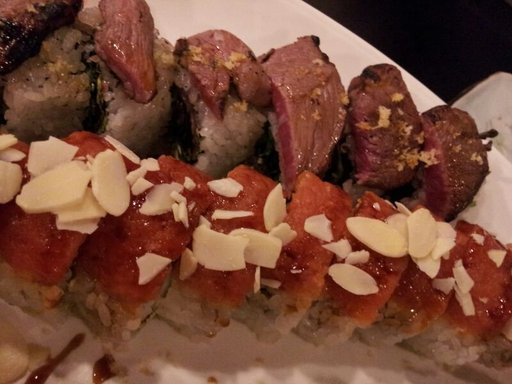

In [7]:
random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
img

(-0.5, 511.5, 383.5, -0.5)

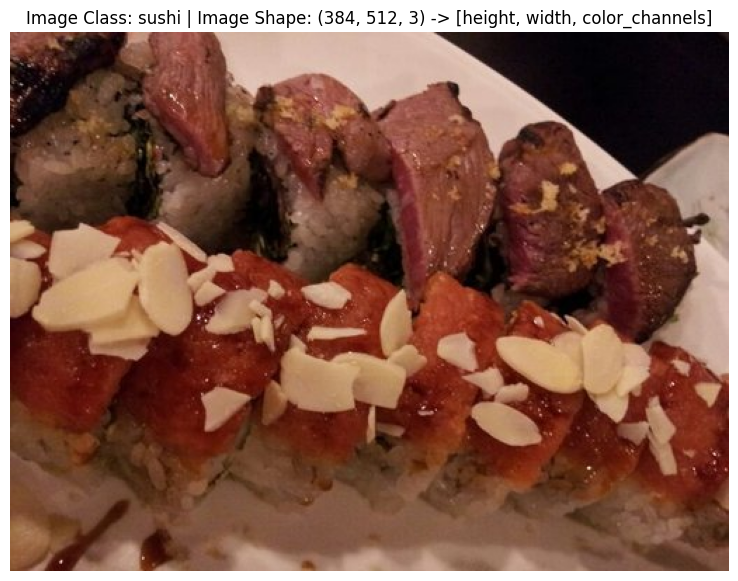

In [8]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Data Transformation

1. Turning data into tensors
2. Turning these tensors into a `torch.utils. data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` a `DataLoader`

In [9]:
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn images into a torch.Tensor
    transforms.ToTensor()
])

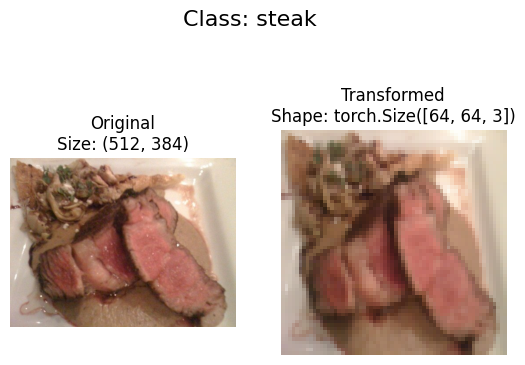

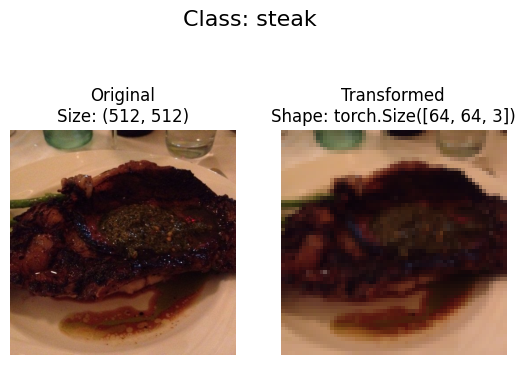

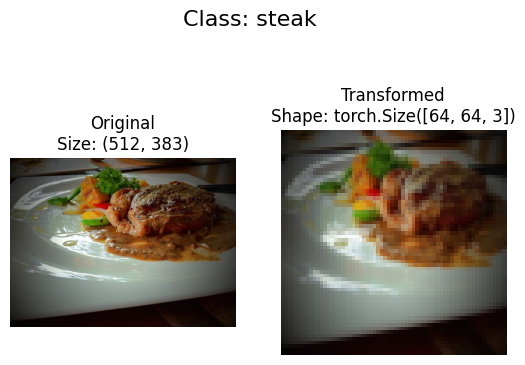

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## Option 1: Image Loading with `ImageFolder`

In [11]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

## Data Loading with `DataLoader`

In [14]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec544c06440>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec544c06b60>)

## Option 2: Custom Image Loading with `Dataset`

### Creating a helper function to get clas names 

1. Get the class names using `os.scandir()` to traverse directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found
3. Turn the class names into a dict and a list and return them.

In [15]:
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [16]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory"""

    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [17]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our sublclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create the following attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - a list  of the target classes
   * classes_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample with passed index

In [18]:
# Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):
    # Initialize our custom dataset
    def __init__(self, targ_dir:str, transform=None):
        # Creatig class attributes
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create a funcion to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)

    # Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)

    # Overwrite __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one smaple of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [19]:
# 22:00:15